# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [40]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from sklearn.linear_model import RANSACRegressor

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


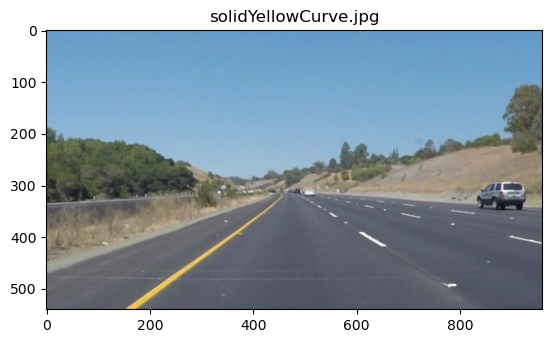

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


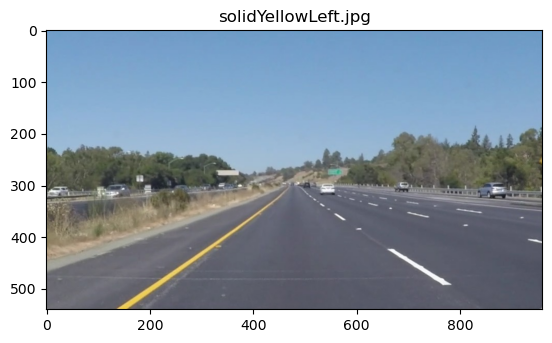

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


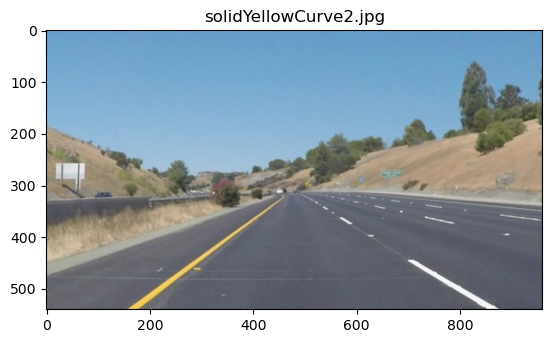

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


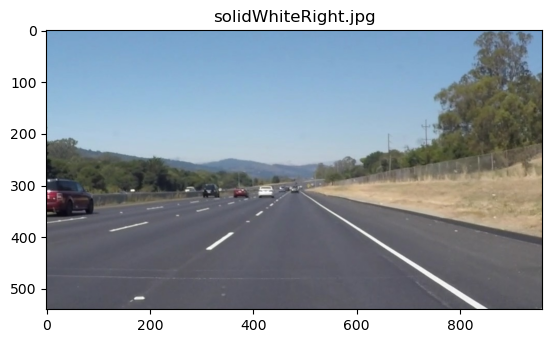

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


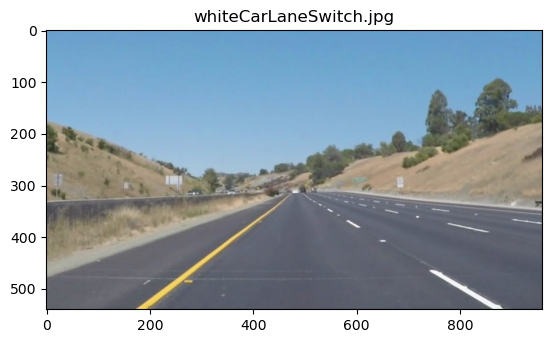

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


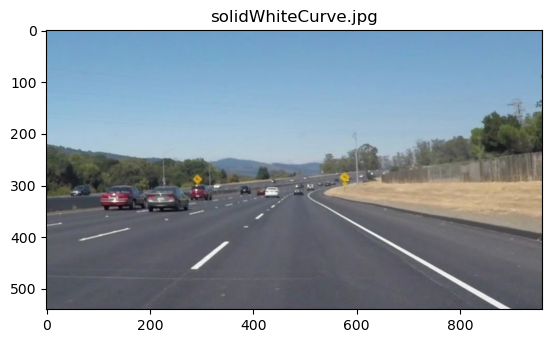

Loaded 6 images into the array.


In [6]:

# Specify the folder containing your images
folder_path = "test_images"  # Replace with your folder path

# Get all image files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Initialize an array to store images
images = []

# Load each image, print stats, and display it
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = mpimg.imread(image_path)  # Read the image
    if image is not None:
        images.append(image)
        # Print stats and display the image
        print(f"This image is: {type(image)} with dimensions: {image.shape}")
        plt.imshow(image)
        plt.title(image_file)  # Add the filename as the title
        plt.show()

print(f"Loaded {len(images)} images into the array.")


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [41]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [42]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 '.ipynb_checkpoints',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

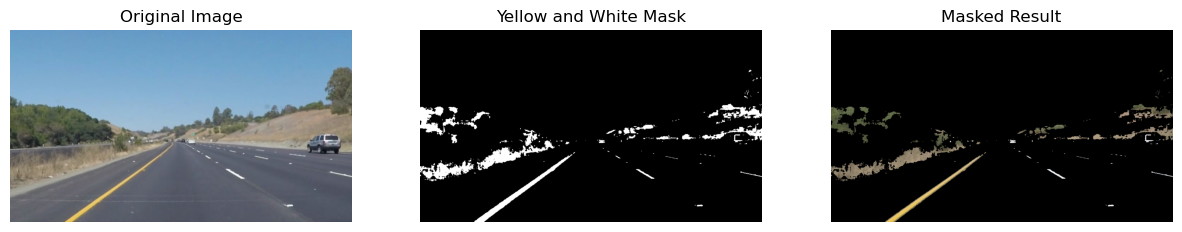

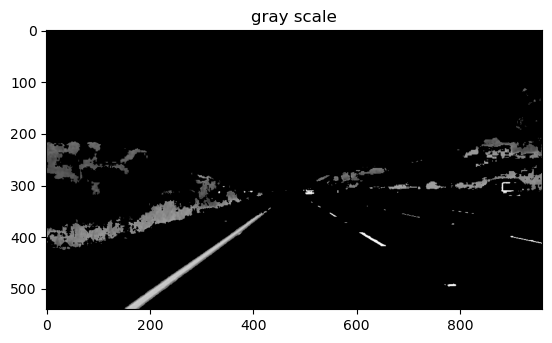

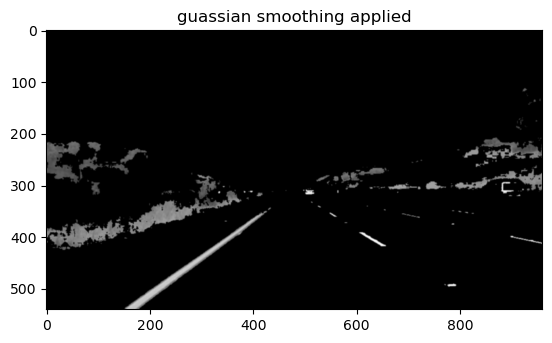

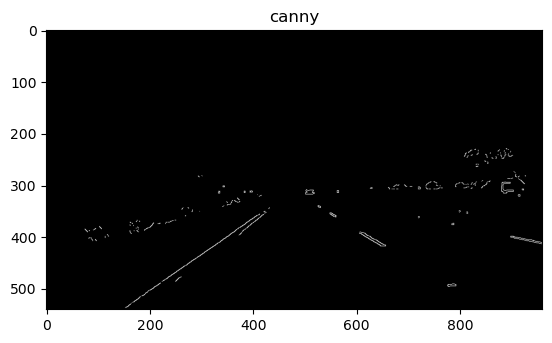

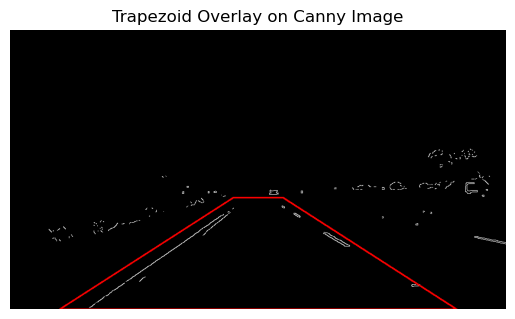

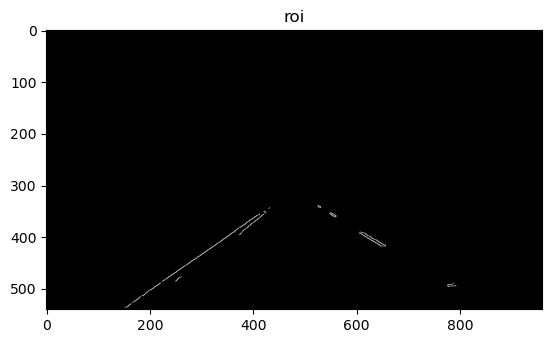

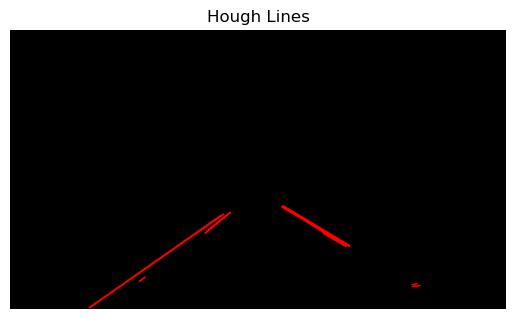

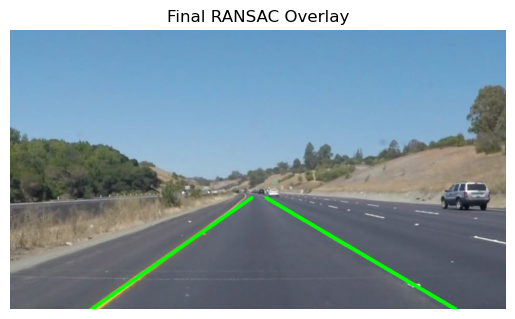

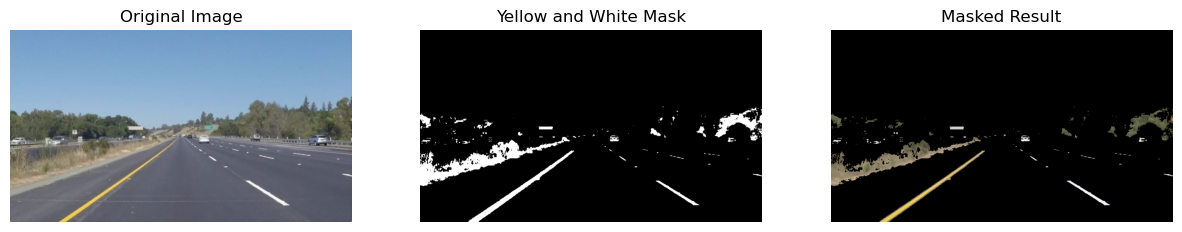

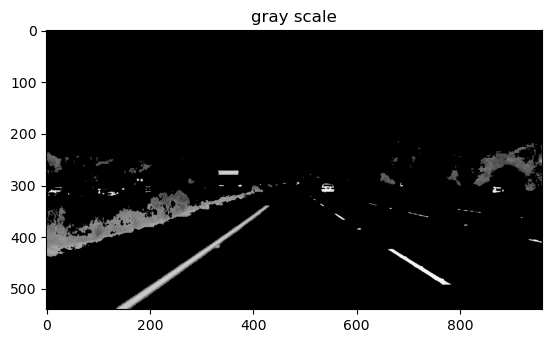

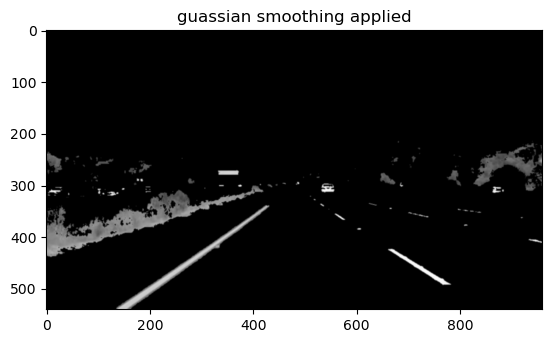

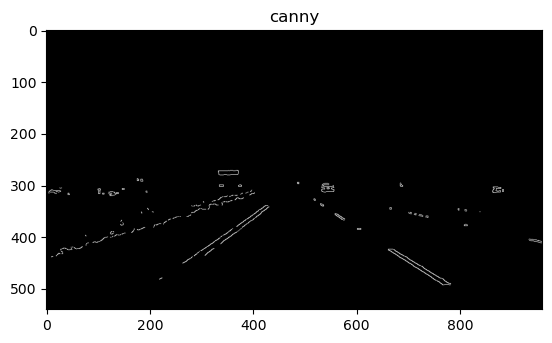

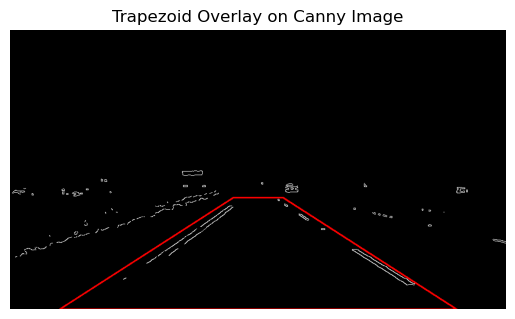

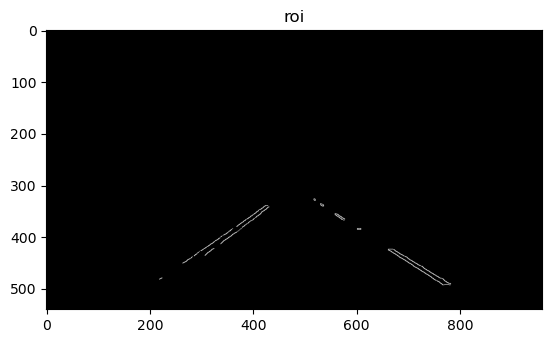

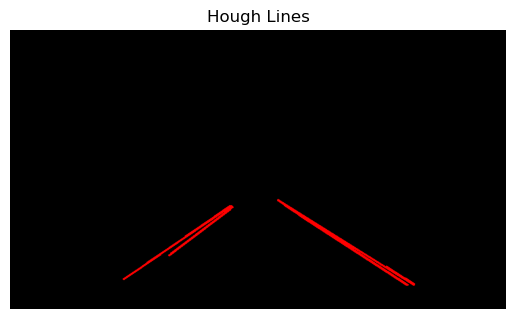

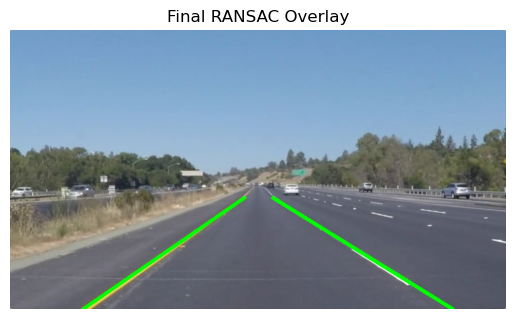

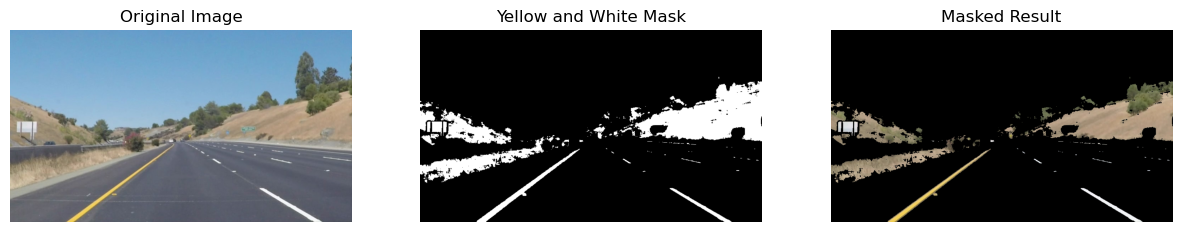

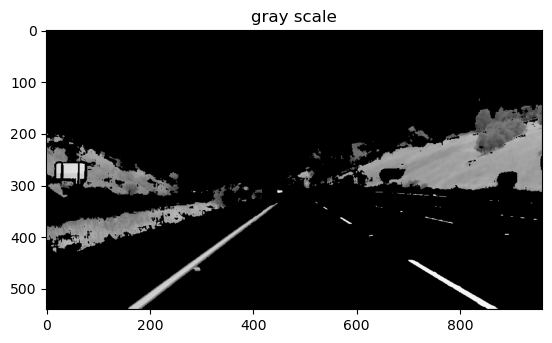

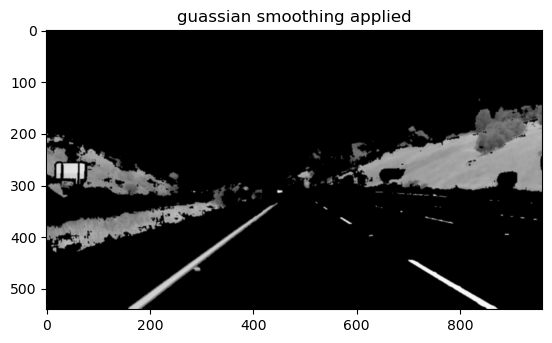

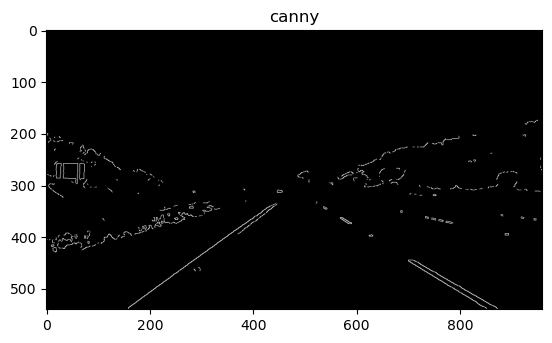

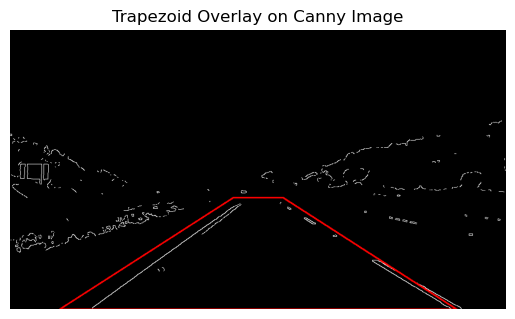

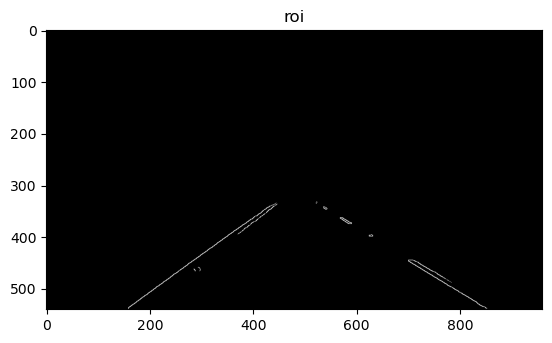

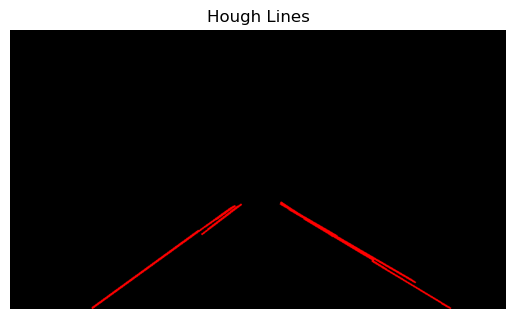

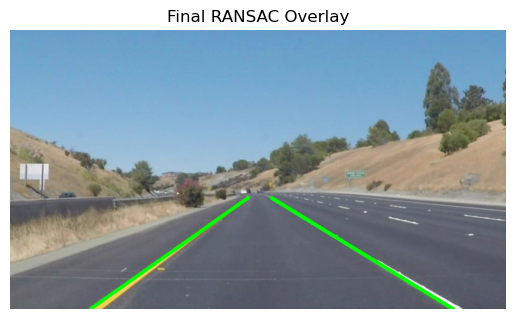

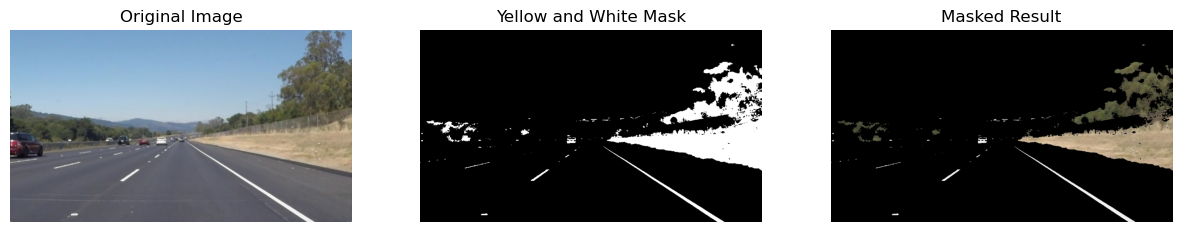

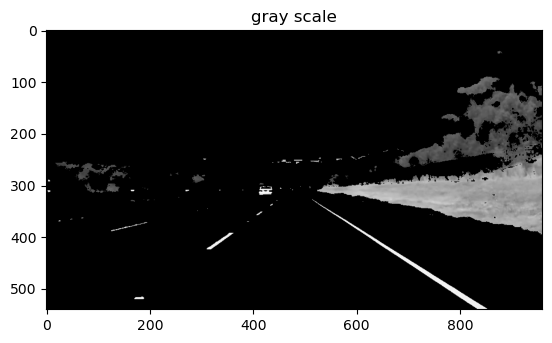

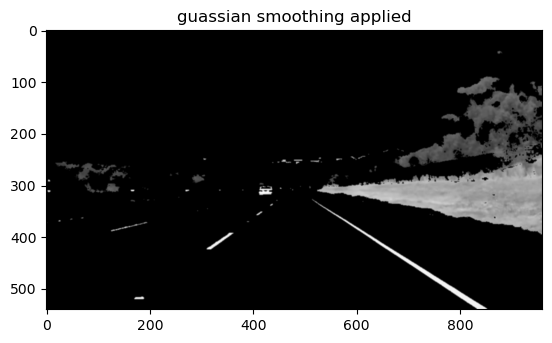

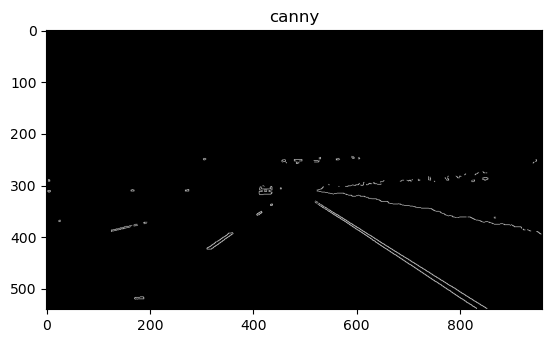

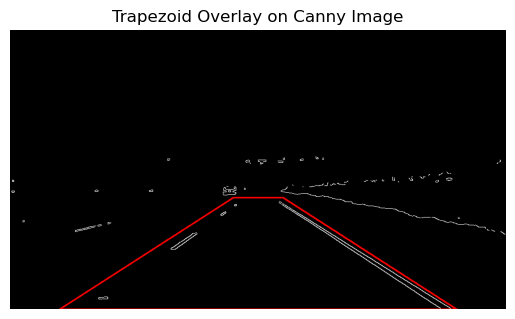

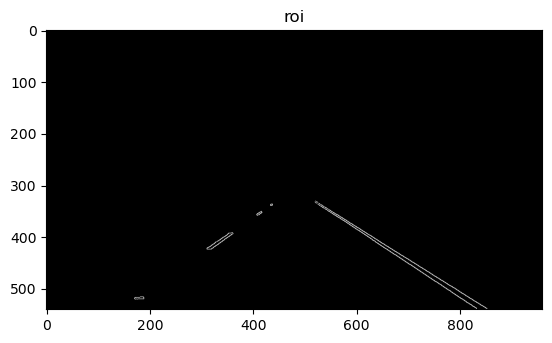

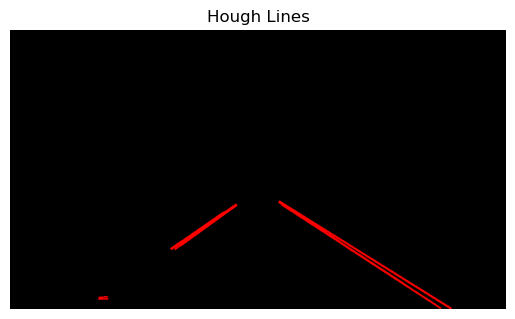

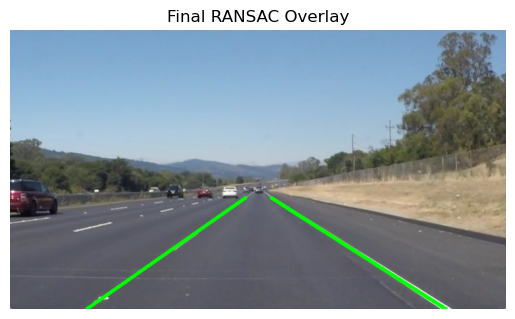

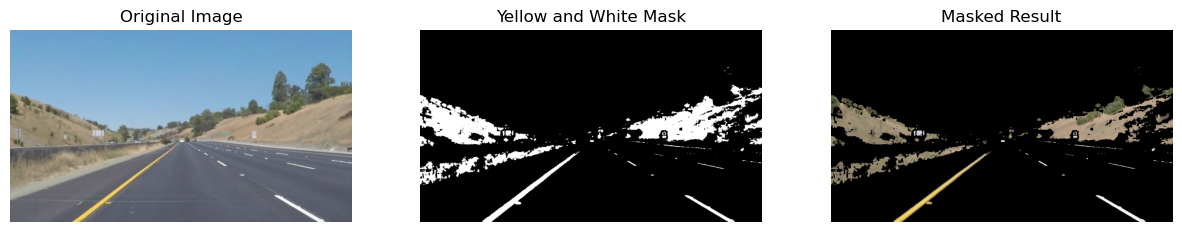

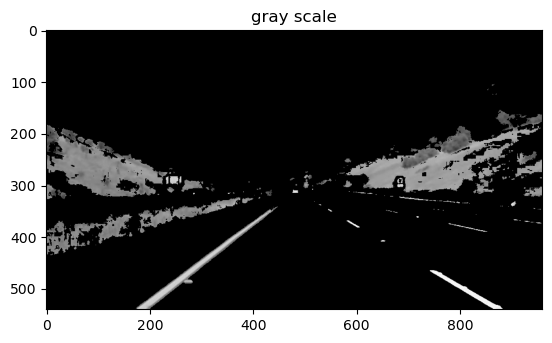

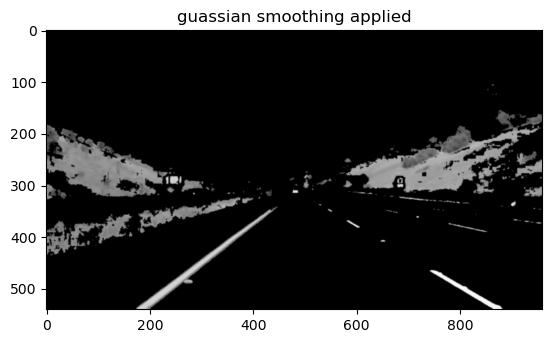

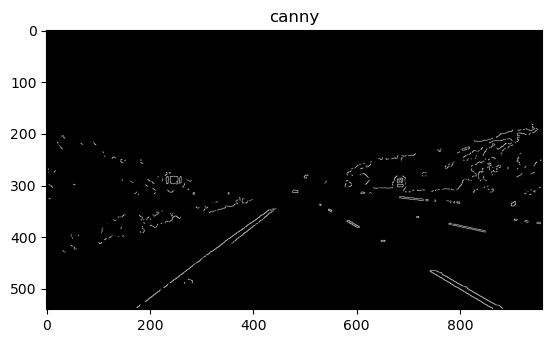

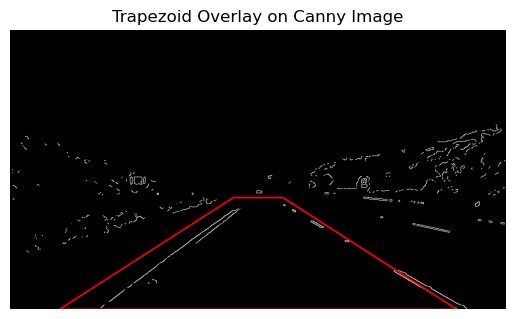

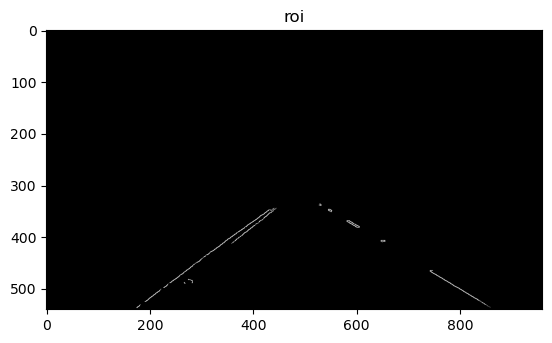

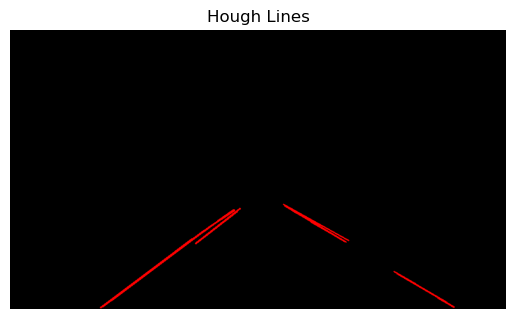

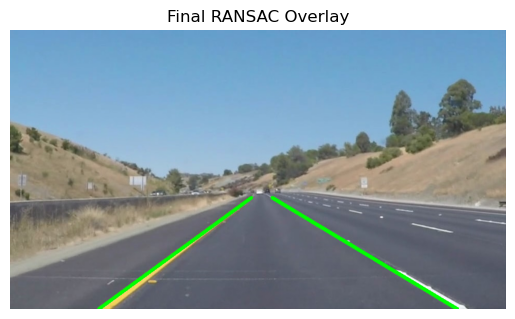

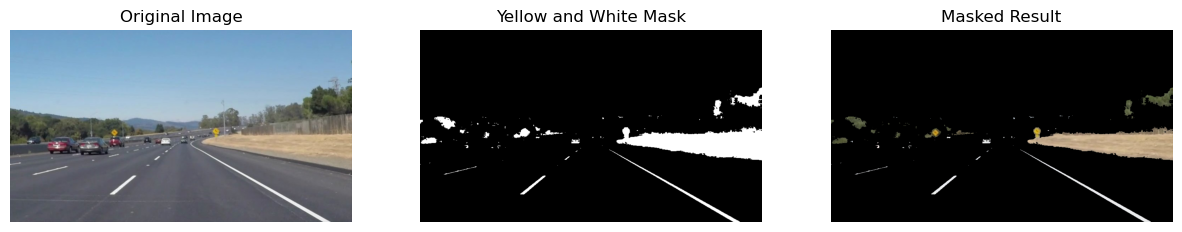

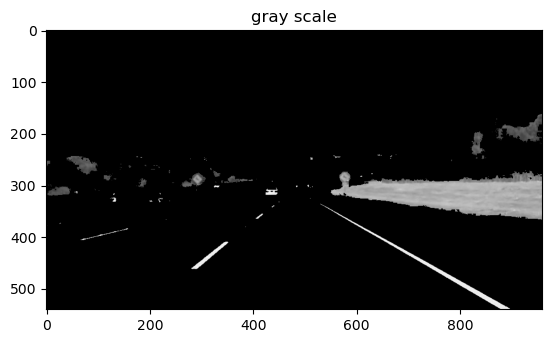

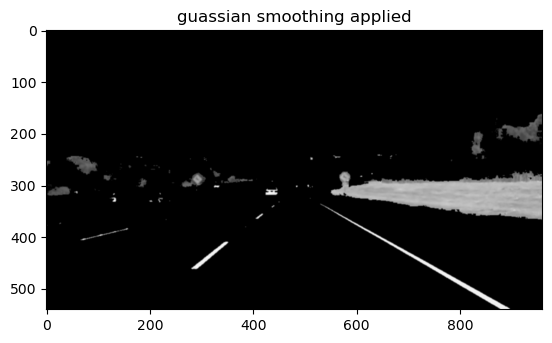

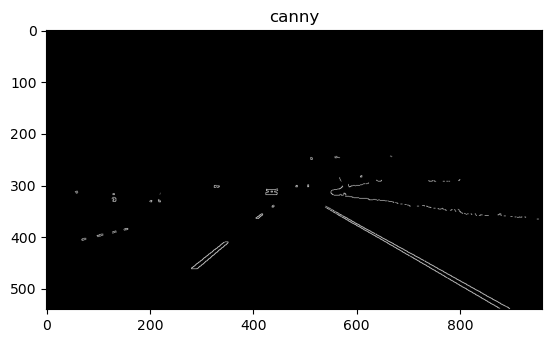

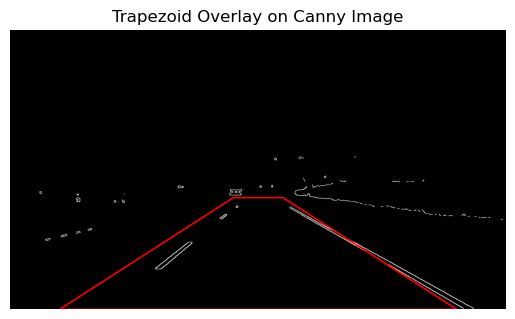

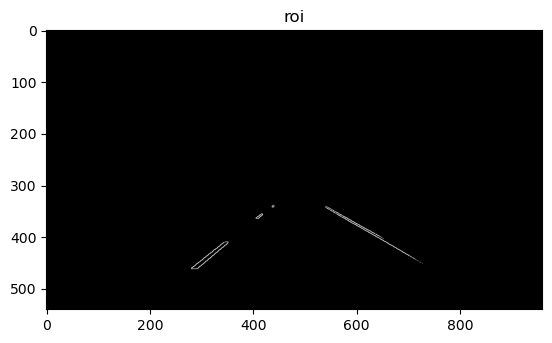

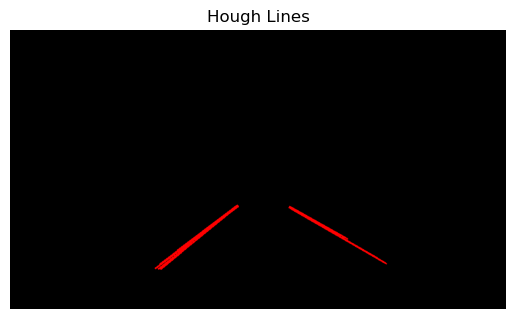

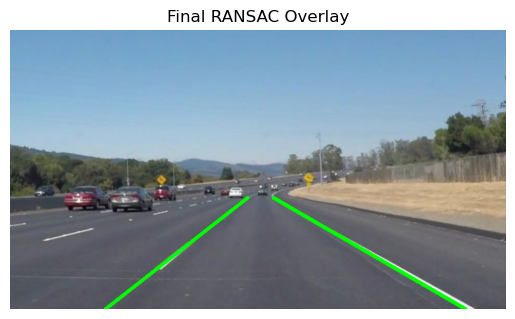

In [75]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def color_thresholding(image):
    """
    Perform color thresholding to isolate yellow and white colors in an image.

    Returns:
        tuple: Original image, mask for yellow and white, and the masked result image.
    """
    # Convert to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define HSV thresholds for yellow
    yellow_lower = np.array([10, 60, 60])
    yellow_upper = np.array([40, 255, 255])

    # Define HSV thresholds for white
    white_lower = np.array([0, 0, 200])
    white_upper = np.array([180, 25, 255])

    # Create masks
    mask_yellow = cv2.inRange(image_hsv, yellow_lower, yellow_upper)
    mask_white = cv2.inRange(image_hsv, white_lower, white_upper)

    # Combine masks
    combined_mask = cv2.bitwise_or(mask_yellow, mask_white)

    # Apply the mask to the original image
    result = cv2.bitwise_and(image, image, mask=combined_mask)

    return image, combined_mask, result

# Display function for Jupyter
def display_images(original, mask, result):
    """
    Display original, mask, and result images side by side in a Jupyter notebook.
    """
    plt.figure(figsize=(15, 10))
    
    # Original image (convert BGR to RGB for proper display)
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Mask image
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Yellow and White Mask")
    plt.axis('off')

    # Result image (convert BGR to RGB for proper display)
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Masked Result")
    plt.axis('off')
    
    plt.show()

def ransac_line(points):
    """
    Fit a line (y = m*x + b) to points using scikit-learn's RANSACRegressor.
    Returns (slope, intercept).
    """
    points = np.array(points)
    if len(points) < 2:
        return None, None  # Not enough points to fit anything

    #need to extrct x coordinates as a 2d array to work with scikit-learn
    x = points[:, [0]] 
    y = points[:, 1]            

    ransac = RANSACRegressor()
    #doing the trial and error to minimize outliers
    ransac.fit(x, y)
    #getting the slope and intercept so we can plot the line on our image
    slope = ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    return slope, intercept

def draw_ransac_line(img, slope, intercept, color=(0, 255, 0), thickness=5):
    """
    Draw a single line (from slope & intercept) on 'img'.
    We'll draw it between y=height and y=some fraction of height (e.g., 60%).
    """
    if slope is None:
        return  # no valid line

    height, width = img.shape[:2]
    y1 = height
    y2 = int(height * 0.6)

    # Avoid dividing by zero
    if abs(slope) < 1e-6:
        return

    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def ransac_from_hough(image, lines):
    """
    1) Collect (x, y) points from the Hough lines
    2) Separate them into left/right by midpoint of the image.
    3) Run RANSAC on each side to get a single slope/intercept.
    4) Draw those lines on 'image' and return it.

    """
    if lines is None:
        return image  # no lines to process

    # Collect all endpoints from Hough lines
    points = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            points.append((x1, y1))
            points.append((x2, y2))

    # Separate left vs right based on midpoint
    height, width = image.shape[:2]
    mid_x = width // 2

    left_points = [(x, y) for (x, y) in points if x < mid_x]
    right_points = [(x, y) for (x, y) in points if x >= mid_x]

    
    m_left, b_left = ransac_line(left_points)
    m_right, b_right = ransac_line(right_points)

    # Draw the RANSAC result lines on the original image
    draw_ransac_line(image, m_left, b_left, color=(0, 255, 0), thickness=5)
    draw_ransac_line(image, m_right, b_right, color=(0, 255, 0), thickness=5)

    return image


def lane_detect():
    for img in images:
        #color thresholding begin
        original, mask, result = color_thresholding(img)
        display_images(original, mask, result)
        #color thresholding end

        #convert into gray scale begin
        gray_result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
        plt.imshow(gray_result, cmap='gray')
        plt.title("gray scale")
        plt.show()
        #convert into gray scale end

        #apply guassian smoothing begin
        gray_result = gaussian_blur(gray_result, 3)
        plt.imshow(gray_result, cmap='gray')
        plt.title("guassian smoothing applied")
        plt.show()
        #apply guassian smoothing end


        #apply canney edge detector begin
        canny_result = canny(gray_result,500,600)
        plt.imshow(canny_result,cmap='gray')
        plt.title("canny")
        plt.show()
        #apply canney edge detector end

        #seeing the overlay begin
        overlay_image = cv2.cvtColor(canny_result, cv2.COLOR_GRAY2BGR)

        height, width = canny_result.shape
        vertices = np.array([[
            (width * 0.1, height),  # Bottom-left corner
            (width * 0.45, height * 0.6),  # Top-left corner
            (width * 0.55, height * 0.6),  # Top-right corner
            (width * 0.9, height)  # Bottom-right corner
        ]], dtype=np.int32)

        # Draw the trapezoid in red
        cv2.polylines(overlay_image, vertices, isClosed=True, color=(0, 0, 255), thickness=2)

        # Show the image with the trapezoid overlay
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title("Trapezoid Overlay on Canny Image")
        plt.axis("off")
        plt.show()
        
        #seeing the overlay end

        #roi begin 
        roi_image = region_of_interest(canny_result, vertices)
        plt.imshow(roi_image,cmap='gray')
        plt.title("roi")
        plt.show()
        #roi end


        # Parameters for the Hough Transform
        rho = 1  # Distance resolution in pixels
        theta = np.pi / 180  # Angle resolution in radians (1 degree)
        threshold = 10  # Minimum number of votes (intersections in Hough grid cell)
        min_line_len = 10  # Minimum length of a line in pixels
        max_line_gap = 80  # Maximum gap between two segments to connect them

        # Apply Hough Line Transform
        hough_image, lines = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)

        # Display the result
        plt.imshow(hough_image)
        plt.title("Hough Lines")
        plt.axis("off")
        plt.show()

        # 3. Now run RANSAC on those lines and draw the final lines on a copy of original
        ransac_overlay = img.copy()
        ransac_overlay = ransac_from_hough(ransac_overlay, lines)
        plt.imshow(ransac_overlay)
        plt.title("Final RANSAC Overlay")
        plt.axis("off")
        plt.show()

        # final_weighted = weighted_img(ransac_overlay, img, α=0.0, β=1.0, γ=0.0)
        # plt.imshow(final_weighted)
        # plt.title("Final Weighted RANSAC Overlay")
        # plt.axis("off")
        # plt.show()
        # break



    

lane_detect()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [52]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
def process_image(image):

    # 1. Color thresholding
    original, mask, result = color_thresholding(image)

    # 2. Convert to grayscale
    gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    # 3. Apply Gaussian smoothing
    gray_result = gaussian_blur(gray_result, 3)

    # 4. Canny edge detection
    canny_result = canny(gray_result, 100, 200)

    # 5. Region of Interest (ROI)
    height, width = canny_result.shape
    vertices = np.array([[
        (width * 0.1, height),
        (width * 0.45, height * 0.6),
        (width * 0.55, height * 0.6),
        (width * 0.9, height)
    ]], dtype=np.int32)
    roi_image = region_of_interest(canny_result, vertices)

    # 6. Hough Lines
    rho = 1  
    theta = np.pi / 180  
    threshold = 10  
    min_line_len = 10  
    max_line_gap = 80
    hough_img, lines = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)

    # 7. RANSAC overlay
    ransac_overlay = image.copy()
    ransac_overlay = ransac_from_hough(ransac_overlay, lines)

 

    return ransac_overlay

Let's try the one with the solid white lane on the right first ...

In [82]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.7 s, sys: 537 ms, total: 2.23 s
Wall time: 2.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [83]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 5.7 s, sys: 1.58 s, total: 7.28 s
Wall time: 6.82 s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


Below is a sample **Writeup** that you can use as a guide. It follows the structure of the project’s “Finding Lane Lines on the Road” template, with additional details about your pipeline, RANSAC modifications, and any relevant insights from displaying each processing step.

---

# **Finding Lane Lines on the Road**

## **Goals of the Project**
1. Make a pipeline that identifies and draws lane lines on **static images**.
2. Extend the same pipeline to work on a **video** of a road, showing continuous lane line detection.
3. Discuss how the pipeline works, what’s been implemented, and potential improvements.

## **Pipeline Description**

### **1. Color Thresholding**
I started by **isolating white and yellow** regions in the image using HSV color thresholds. This makes it easier to work with lines that are actually lane markings:
- **Yellow mask**: `[10, 60, 60]` to `[40, 255, 255]` in HSV  
- **White mask**: `[0, 0, 200]` to `[180, 25, 255]`

Those two masks get combined via a bitwise OR (`cv2.bitwise_or`) to produce a single `combined_mask` that captures both yellow and white pixels. Finally, I apply that mask to the original image to focus on the relevant colors.

$\text{masked\_image} = \text{original\_image} \,\&\, \text{combined\_mask}$

### **2. Convert to Grayscale**
Next, the masked result is converted to **grayscale**. This condenses the color information into a single intensity channel, which is a standard approach before edge detection.

### **3. Gaussian Smoothing**
I apply a **Gaussian blur** to the grayscale image to reduce high-frequency noise. This helps create smoother edges and prevents false positives in the next step (Canny edge detection). In the code, the kernel size is set to 3.

### **4. Canny Edge Detection**
I run a **Canny edge detector** on the blurred grayscale image. Parameters (e.g., 100 and 200) control how sensitive the detector is. The output is a binary image where potential edges (lane boundaries) are highlighted.

### **5. Region of Interest (ROI)**
In most road images, we only care about the region **below the horizon**—roughly a trapezoid covering the part of the road in front of the car. So, I apply a **polygonal mask** that zeros out pixels outside this trapezoid. That helps the pipeline ignore irrelevant parts of the image.

### **6. Hough Lines**
With a masked edge image, I run the **Hough Transform** to find straight line segments:
- **rho** = 1  
- **theta** = $\pi/180$  
- **threshold** = 10  
- **min_line_len** = 10  
- **max_line_gap** = 80  

This produces a list of line segments (each defined by two endpoints).

### **7. RANSAC to Merge Lines**
Instead of drawing all those little Hough lines directly, I use **RANSAC** to create one clean line per lane side. Here’s how:
1. Collect all Hough line endpoints $(x_1, y_1, x_2, y_2)$.  
2. Split them into **left_points** and **right_points** based on whether the x-coordinate is less than or greater than the **midpoint** of the image.  
3. For each side, I run `scikit-learn`’s **RANSACRegressor** to fit a straight line $y = mx + b$. This robustly ignores outliers that might not be part of the main lane boundary.  
4. Finally, I draw one line on the left side and one line on the right side.  

### **8. Drawing the Lines**
Once I have a slope $m$ and intercept $b$ for each side, I choose a vertical span in my region of interest (e.g., from $y = \text{height}$ up to $y = 0.6 \times \text{height}$) and compute $x$-coordinates using $x = \frac{(y - b)}{m}$.  
I call `cv2.line()` to overlay these lines on my original color image.

### **Plotting Each Step (Static Images)**
When testing on **static images**, I displayed each stage (masked image, grayscale, blurred, edges, ROI, Hough lines, final RANSAC lines) so I could visually confirm each step was working properly. This was especially helpful for debugging the color threshold if the yellow lines weren’t getting picked up.

---

## **How the `draw_lines()` Function was Modified**
Originally, `draw_lines()` would draw **all** Hough line segments. Instead, I replaced that with a **RANSAC** approach in `ransac_from_hough()` that:
1. Categorizes line endpoints into left/right sets (based on x-coordinates).  
2. Fits a **single** line per side using `ransac_line()`.  
3. Draws just **two** lines (one for each lane boundary).  

This drastically cleans up the output, avoiding a bunch of short lines.

---

## **Potential Shortcomings**

1. **Curved Roads**  
   My pipeline currently fits only straight lines using RANSAC. If the lane significantly curves, or if we’re on a hill/valley, one straight line might not accurately represent the true boundary.

2. **Lighting and Shadows**  
   Bright sunlight, heavy shadows, or night-time driving might throw off the color thresholding. If the yellow lines are faded or the road is highly reflective, the HSV thresholds might not capture them accurately.

3. **Camera Position**  
   If the camera perspective drastically changes or if the region of interest isn’t well placed, we might cut out the actual lane lines or keep too many irrelevant edges.

---

## **Possible Improvements**

1. **Use a Polynomial Fit**  
   Instead of a straight line with RANSAC, use a **second-order polynomial** for curved lanes (common in advanced lane detection). We could implement a polynomial RANSAC or a sliding-window approach.

2. **Adaptive Thresholding or Color Conversion**  
   If lighting varies a lot, we could dynamically adjust thresholds or even use a different color space (like LAB or LUV) that might be more robust to brightness changes.

---

## **Conclusion**

Overall, the pipeline successfully detects lane lines in most standard conditions by:
- Isolating yellow/white in **HSV**,
- Filtering with a **Region of Interest**,
- Applying **Hough** + **RANSAC** to merge lines.

While it works well for relatively straight roads and decent lighting, more sophisticated methods or polynomial fitting might be required for robust real-world deployment. However, by plotting each step, I could confirm the intermediate results and tune parameters (like color thresholds) for the best possible outcome on my test images and video clip.



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [87]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 4.87 s, sys: 1.08 s, total: 5.95 s
Wall time: 5.84 s


In [88]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))